# This notebook is for inference on test data given in the interview

## Load libraries

In [1]:
import utils
from feature_engineering import FeatureEngineering
import metrics

In [2]:
import pandas as pd
import numpy as np
import metrics
import utils
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import pickle
import glob
import joblib

In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.utils.class_weight import compute_class_weight
import xgboost as xgb

/home/ntng/.local/lib/python3.8/site-packages/xgboost/core.py:265: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc 2.28+) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.
  warnings.warn(


## Declare path to test data

In [4]:
# we define the path to the test dataset
path_to_test_data = 'datasets'

## Internal processing

In [5]:
# here are some internal constants
path_to_data4dev = 'assets/data4dev.csv'
path_to_data_scaler = 'assets/data_scaler.pkl'
path_to_data_inf_org = 'assets/path_to_data_orig_inf.csv'
path_to_data_inf_transformed = 'assets/path_to_data_dev_inf.csv'
model_path = {'lr': 'results/lr_model.pkl',
              'xgb': 'results/xgb_model.pkl'}
model_to_use = 'xgb'

In [6]:
# load data
df = utils.load_data(nonfraud_path=glob.glob(f"{path_to_test_data}/*_nonfraud_*.csv"), fraud_path=glob.glob(f"{path_to_test_data}/*_fraud*.csv"))
df.to_csv(path_to_data_inf_org, index=False) # we need to store this for report generation

In [7]:
# transform data
fe = FeatureEngineering(df)
transformed_df = fe.transform() 
transformed_df.to_csv(path_to_data_inf_transformed, index=False)

In [8]:
# prepare data for inference
is_with_label = True
col_to_drop = ['id']
if is_with_label:
    col_to_drop.append('fraud')

X = transformed_df.drop(col_to_drop, axis=1)
y = transformed_df['fraud']


In [9]:
# scale data
data_scaler = joblib.load(path_to_data_scaler)
X_standardized = data_scaler.transform(X)

In [10]:
clf = utils.load_model(model_path[model_to_use])
model = model_to_use + '_test'

if model_to_use in ['lr', 'dt']:
    y_pred = clf.predict(X_standardized)
elif model_to_use == 'xgb':
    dtest = xgb.DMatrix(X_standardized, label=y, feature_names=X.columns.tolist())
    y_pred_proba = clf.predict(dtest)    
    y_pred = (y_pred_proba > 0.5).astype(int)

# Evaluate models and generate report

F1: 0.9948186528497409
ROC AUC: 0.9948453608247423
ROC PR: 0.9896913585747152
Sensitivity (Recall): 0.9896907216494846
Specificity: 1.0


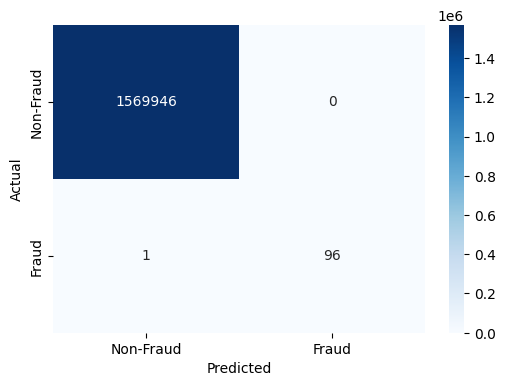

array([[1569946,       0],
       [      1,      96]])

In [11]:
print("F1:", metrics.calc_f1(y, y_pred))
print("ROC AUC:", metrics.calc_auc_roc(y, y_pred))
print("ROC PR:", metrics.calc_auc_pr(y, y_pred))
print("Sensitivity (Recall):", metrics.calc_sensitivity(y, y_pred))
print("Specificity:", metrics.calc_specificity(y, y_pred))
metrics.generate_confusion_matrix(y, y_pred, model + '_confusion_matrix.png')

In [ ]:
if model_to_use == 'lr':
    y_pred_proba = clf.predict_proba(X_standardized)
elif model_to_use == 'xgb':
    y_pred_proba = y_pred_proba.reshape((-1, 1))
    y_pred_proba = np.hstack([np.zeros((y_pred_proba.shape[0], 1)), y_pred_proba])
    
utils.generate_prediction_report(path_to_data_inf_org, path_to_data_inf_transformed, y, y_pred, y_pred_proba, 'prediction_report.csv')